# "Bag of Words" model for Product Recommendation System

# A. Objective
- Model should recommend only those product having words in title text like black, strips, printed, top, shirt, etc.

# B. Title Text
- We are using "processed_title" column.
- This column does not contains words like brand name and different size of same product.
- 'Bag of Words' model may recommend different products of same brand name, so we removed brand name from title text. 
- It will also recommend same product of different sizes, so we removed data points having different sizes.

# C. Approch
- We will convert processed titles into sparse matrices using 'CountVectorizer()'
- Then we will calculate distances between query points using 'pairwise_distances'
- 'pairwise_distances' contains many metrics to calculate distance but 'euclidean' and 'cosine' metrics supports sparse matrices and are faster.
- So, after comparision between these two metrics we will finalize one metric for pairwise distance calculations.

In [1]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
import requests
from io import BytesIO
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_pickle('16k_processed_data')

In [3]:
data.head()

,asin,brand,medium_image_url,product_type_name,color,title,formatted_price,processed_title
0,B06Y1KZ2WB,Éclair,https://images-na.ssl-images-amazon.com/images...,SHIRT,Black/Pink,Éclair Women's Printed Thin Strap Blouse Black...,$24.99,women printed thin strap blouse junior
1,B010RV33VE,xiaoming,https://images-na.ssl-images-amazon.com/images...,SHIRT,Pink,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19,womens sleeveless loose long shirts top blouse
2,B01DDSDLNS,xiaoming,https://images-na.ssl-images-amazon.com/images...,SHIRT,White,xiaoming Women's White Long Sleeve Single Brea...,$21.58,women white long sleeve single breast loose co...
3,B00X5LYO9Y,xiaoming,https://images-na.ssl-images-amazon.com/images...,SHIRT,Red Anchors,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91,stripes tank patch bear sleeve anchor short em...
4,B00WPJG35K,xiaoming,https://images-na.ssl-images-amazon.com/images...,SHIRT,White,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32,sleeve sheer loose tassel kimono woman chiffon...


In [4]:
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['processed_title'])
title_features.get_shape() # returns number of rows and columns in feature matrix.

(16119, 9915)

In [5]:
# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc
print(title_features[0])

  (0, 9715)	1
  (0, 7138)	1
  (0, 8907)	1
  (0, 8548)	1
  (0, 1836)	1
  (0, 5052)	1


In [6]:
# function to display image of product using 'medium_image_url' of product.
def display_img(url):
    # we will use  'medium_imge_url' of the product.
    fig = plt.figure(figsize=(25,3))
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.show()

# A. Bag of Words model ('euclidean' metric)

ASIN : B00JMNYJTE | Brand : Love My Seamless


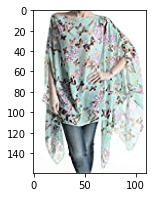

Title: Womens Juniors Fashion Butterfly Poncho Tunic Caftan Cover up One Size Scarf Top
Euclidean distance with the query point : 0.0
ASIN : B00L2L4KIO | Brand : Love My Seamless


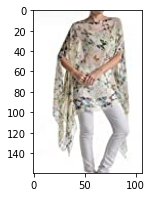

Title: Womens Juniors Fashion Shawl Tunic Poncho Butterfly Cover up One Size Scarf Top
Euclidean distance with the query point : 1.4142135623730951
ASIN : B00L2L4EWG | Brand : Love My Seamless


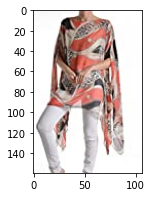

Title: Womens Juniors Fashion Shawl Tunic Poncho Leopard Coral Cover up One Size Scarf Top
Euclidean distance with the query point : 2.23606797749979
ASIN : B00JOO52XS | Brand : Love My Seamless


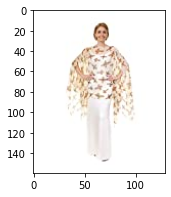

Title: Womens Junior Fashion Chiffon Cross Caftan Tunic Poncho Cover One Size Scarf Top
Euclidean distance with the query point : 2.23606797749979
ASIN : B00MMQXZTS | Brand : Love My Seamless


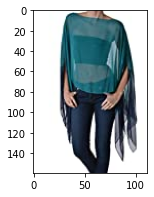

Title: Womens Fashion Teal Shawl Scarf Poncho Kimono Caftan Chiffon One Size Tunic Top
Euclidean distance with the query point : 2.6457513110645907
ASIN : B06XX71PYX | Brand : BCX


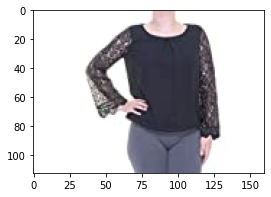

Title: BCX Juniors' Black Top Size S
Euclidean distance with the query point : 3.0
ASIN : B01CE40VX0 | Brand : Marolaya


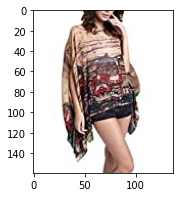

Title: Marolaya Womens Chiffon Caftan Poncho Tunic Floral Plus Size Cover up
Euclidean distance with the query point : 3.0
ASIN : B01LXDHZRT | Brand : Energie


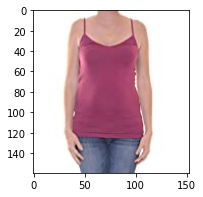

Title: Energie Juniors' Top Size M
Euclidean distance with the query point : 3.0
ASIN : B06XXJFR2K | Brand : Rebellious One


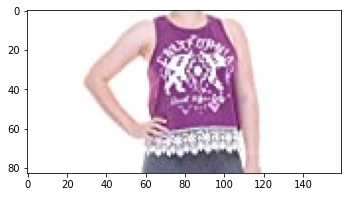

Title: Rebellious One Juniors' Sleeveless Tank Top Size L
Euclidean distance with the query point : 3.1622776601683795
ASIN : B01N0NWG0K | Brand : One Clothing


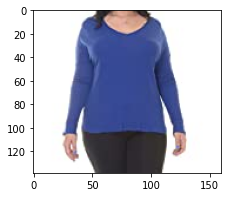

Title: One Clothing Juniors' High-Low Tunic Top Size XL
Euclidean distance with the query point : 3.1622776601683795


In [7]:
def bag_of_words_pd_euclidean_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    # num_results : number of recommended products including selected 'doc_id' product.

    # pairwise_distances with 'euclidean' metric
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id], metric='euclidean')

    # by np.'sort', pdists will store the smallest distances
    pdists = np.sort(pairwise_dist.flatten())[0:num_results] 

    # np.'arg'sort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results] 
    
    # dataframe indices of the smallest distance's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        print('ASIN : {0} | Brand : {1}'.format(data['asin'].loc[df_indices[i]],data['brand'].loc[df_indices[i]]))
        display_img(data['medium_image_url'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean distance with the query point :', pdists[i])
        print('='*100)

bag_of_words_pd_euclidean_model(838, 10) 

# B. Bag of Words model ('cosine' metric)

ASIN : B00JMNYJTE | Brand : Love My Seamless


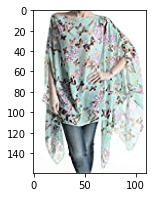

Title: Womens Juniors Fashion Butterfly Poncho Tunic Caftan Cover up One Size Scarf Top
Cosine distance with the query point : 0.0
ASIN : B00L2L4KIO | Brand : Love My Seamless


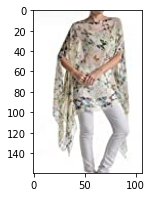

Title: Womens Juniors Fashion Shawl Tunic Poncho Butterfly Cover up One Size Scarf Top
Cosine distance with the query point : 0.08333333333333304
ASIN : B00JOO52XS | Brand : Love My Seamless


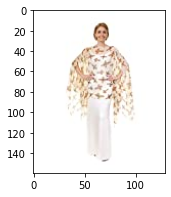

Title: Womens Junior Fashion Chiffon Cross Caftan Tunic Poncho Cover One Size Scarf Top
Cosine distance with the query point : 0.1993592309745642
ASIN : B00L2L4EWG | Brand : Love My Seamless


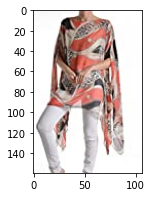

Title: Womens Juniors Fashion Shawl Tunic Poncho Leopard Coral Cover up One Size Scarf Top
Cosine distance with the query point : 0.1993592309745642
ASIN : B00MMQXZTS | Brand : Love My Seamless


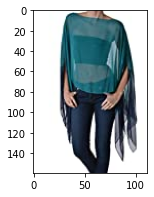

Title: Womens Fashion Teal Shawl Scarf Poncho Kimono Caftan Chiffon One Size Tunic Top
Cosine distance with the query point : 0.2794233078771078
ASIN : B06XV8RDLG | Brand : Odishabazaar


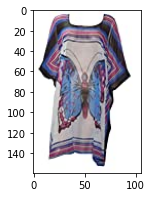

Title: Odishabazaar Women Chiffon Butterfly Print Caftan Tunic Poncho Top One Size (pl-2737)
Cosine distance with the query point : 0.4166666666666665
ASIN : B01CE40VX0 | Brand : Marolaya


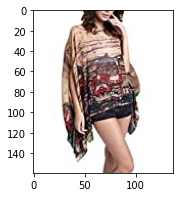

Title: Marolaya Womens Chiffon Caftan Poncho Tunic Floral Plus Size Cover up
Cosine distance with the query point : 0.42264973081037416
ASIN : B0733Z1VKV | Brand : Modern Kiwi


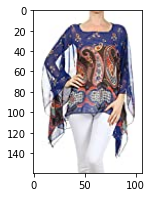

Title: Modern Kiwi Breezy Paisley Caftan Poncho Tunic Top Blue One Size
Cosine distance with the query point : 0.4777670321329065
ASIN : B01N0NWG0K | Brand : One Clothing


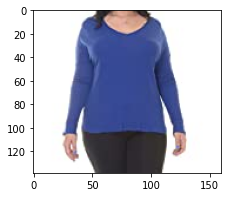

Title: One Clothing Juniors' High-Low Tunic Top Size XL
Cosine distance with the query point : 0.4896896369201712
ASIN : B01LXDHZRT | Brand : Energie


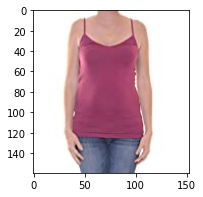

Title: Energie Juniors' Top Size M
Cosine distance with the query point : 0.4999999999999999


In [8]:
def bag_of_words_pd_cosine_model(doc_id, num_results):

    # pairwise_distances with 'cosine' metric
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id], metric='cosine')
    pdists = np.sort(pairwise_dist.flatten())[0:num_results] 
    indices = np.argsort(pairwise_dist.flatten())[0:num_results] 
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        print('ASIN : {0} | Brand : {1}'.format(data['asin'].loc[df_indices[i]],data['brand'].loc[df_indices[i]]))
        display_img(data['medium_image_url'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Cosine distance with the query point :', pdists[i])
        print('='*100)

bag_of_words_pd_cosine_model(838, 10) 

- From the above result, recommended titles contians either 'Caftan', 'Shawl', or 'Chiffon'.
- In model, "euclidean" metric showed only five similar products while "cosine" metric showed seven similar products.
- Let's check time taking for recommendations and product similarity for these two model to finalize our metric.

In [9]:
def bag_of_words_metrics_model(doc_id, num_results): 
    # 'euclidean' metric -
    start_time1 = time.perf_counter()
    pairwise_dist1 = pairwise_distances(title_features,title_features[doc_id], metric='euclidean')
    pdists1 = np.sort(pairwise_dist1.flatten())[0:num_results] 
    indices1 = np.argsort(pairwise_dist1.flatten())[0:num_results] 
    df_indices1 = list(data.index[indices1])
    print('Eucliden metric model')
    for i in range(0,len(indices1)):
        display_img(data['medium_image_url'].loc[df_indices1[i]])
    print("Time for 'euclidean' metric {0} seconds.".format(time.perf_counter() - start_time1))
    print('='*100)

    # 'cosine' metric -
    start_time2 = time.perf_counter()
    pairwise_dist2 = pairwise_distances(title_features,title_features[doc_id], metric='cosine')
    pdists2 = np.sort(pairwise_dist2.flatten())[0:num_results] 
    indices2 = np.argsort(pairwise_dist2.flatten())[0:num_results] 
    df_indices2 = list(data.index[indices2])
    print('Cosine metric model')
    for i in range(0,len(indices2)):
        display_img(data['medium_image_url'].loc[df_indices2[i]])
    print("Time for 'cosine' metric {0} seconds.".format(time.perf_counter() - start_time1))
    print('='*100)

Eucliden metric model


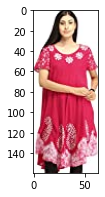

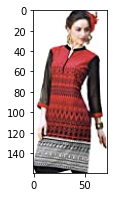

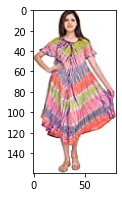

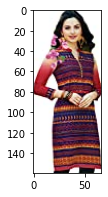

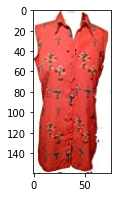

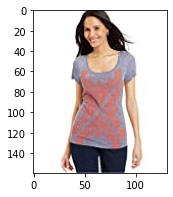

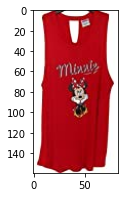

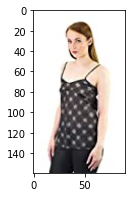

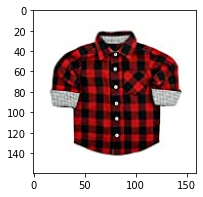

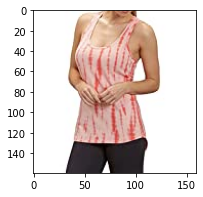

Time for 'euclidean' metric 2.6249681999979657 seconds.
Cosine metric model


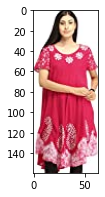

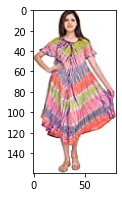

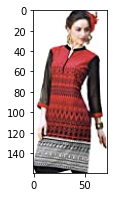

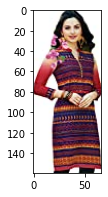

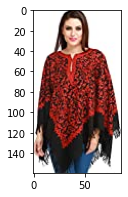

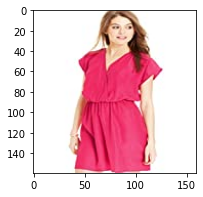

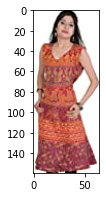

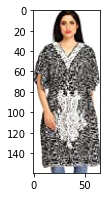

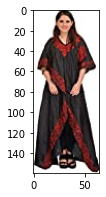

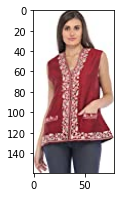

Time for 'cosine' metric 4.543819300000905 seconds.


In [10]:
bag_of_words_metrics_model(11494,10)

Eucliden metric model


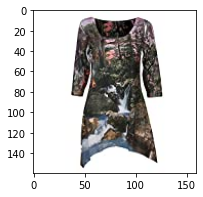

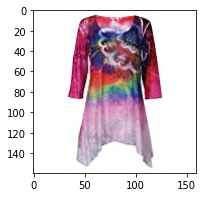

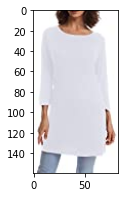

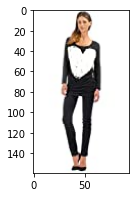

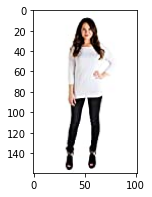

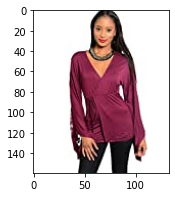

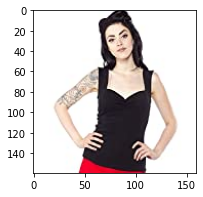

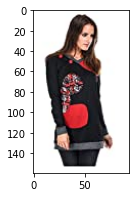

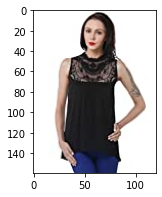

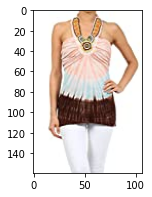

Time for 'euclidean' metric 2.064946600003168 seconds.
Cosine metric model


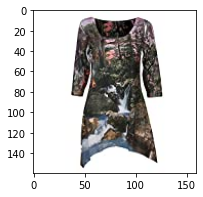

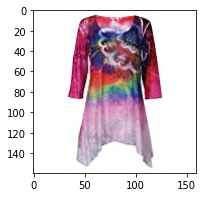

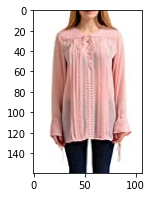

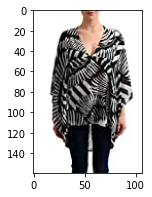

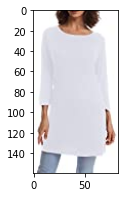

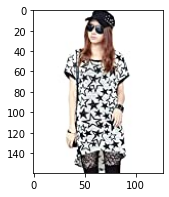

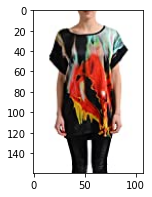

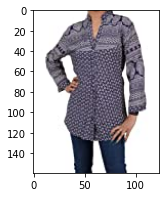

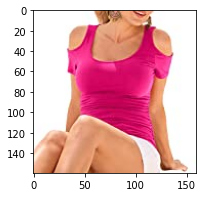

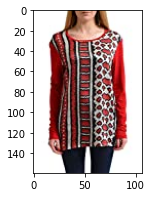

Time for 'cosine' metric 4.907474600000569 seconds.


In [11]:
bag_of_words_metrics_model(955,10)

- From the above observations it is cear that 'euclidean' metric model recommending 5/10 similar products, while 'cosine' metric model recommending 8/10 similar products.
- In terms of time, 'euclidean' metric taking less time to recommend products.
- So for low latency we will choose 'euclidean' metric to calculate pairwise distances.

In [12]:
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id], metric='euclidean')
    pdists = np.sort(pairwise_dist.flatten())[0:num_results] 
    indices = np.argsort(pairwise_dist.flatten())[0:num_results] 
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        print('ASIN : {0} | Brand : {1}'.format(data['asin'].loc[df_indices[i]],data['brand'].loc[df_indices[i]]))
        display_img(data['medium_image_url'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query point :', pdists[i])
        print('='*100)

ASIN : B01N4GOOZQ | Brand : Hippie Rose


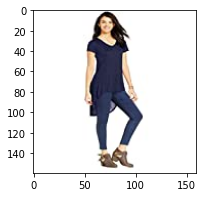

Title: Hippie Rose Juniors' High-Low Top Shirt Small Navy
Euclidean similarity with the query point : 0.0
ASIN : B0711QJHTY | Brand : Hippie Rose


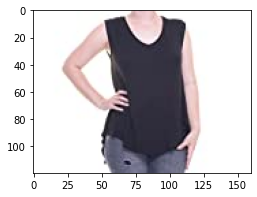

Title: Hippie Rose Juniors' V-Neck High-Low Top Size M
Euclidean similarity with the query point : 2.23606797749979
ASIN : B01NBG0XE8 | Brand : Hippie Rose


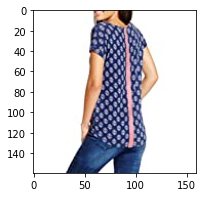

Title: Hippie Rose Juniors' Striped Zipper-Back Top Navy Small
Euclidean similarity with the query point : 2.449489742783178
ASIN : B071LGG5L1 | Brand : Hippie Rose


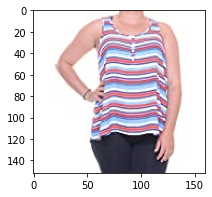

Title: Hippie Rose Juniors' Henley High-Low Tank Top Size L
Euclidean similarity with the query point : 2.449489742783178
ASIN : B01NCO057A | Brand : Hippie Rose


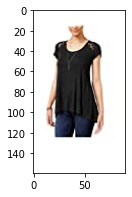

Title: Hippie Rose Juniors Lace-Trim High-Low Top Black Large
Euclidean similarity with the query point : 2.449489742783178
ASIN : B06XS6C7K7 | Brand : Hippie Rose


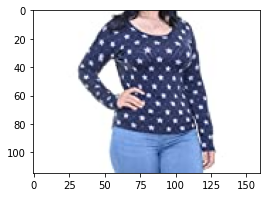

Title: Hippie Rose Juniors' Striped Back-Zipper High-Low Top Size S
Euclidean similarity with the query point : 2.6457513110645907
ASIN : B01JNZJ742 | Brand : Hippie Rose


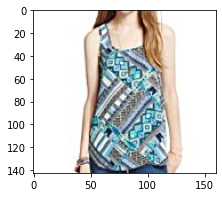

Title: Hippie Rose Juniors' Printed High-Low Top, Blue Patchwork, Large
Euclidean similarity with the query point : 2.6457513110645907
ASIN : B072F297YS | Brand : Hippie Rose


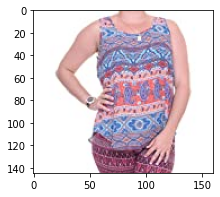

Title: Hippie Rose Juniors' Top Orange Size L
Euclidean similarity with the query point : 2.6457513110645907
ASIN : B00WFCTB06 | Brand : Heather by Bordeaux


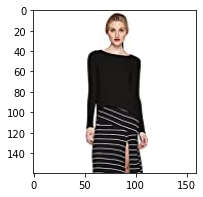

Title: Heather by Bordeaux Asymmetrical High Low Top Extra Small Black
Euclidean similarity with the query point : 2.6457513110645907
ASIN : B01LWVX3NV | Brand : All Is One


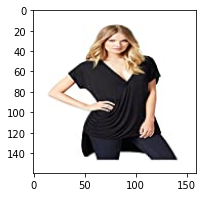

Title: All @ Once High-Low Surplice Top XL Black
Euclidean similarity with the query point : 2.6457513110645907


In [13]:
bag_of_words_model(9775, 10) 

ASIN : B017YMFK06 | Brand : Namnoi Cute Tee Top


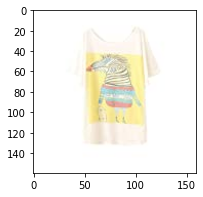

Title: Women's Cute Pastel Tops Tees Zebra Design Print (Size M)
Euclidean similarity with the query point : 0.0
ASIN : B017YMNAF8 | Brand : Namnoi Cute Tee Top


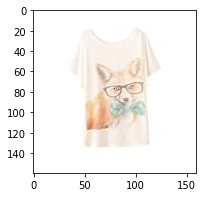

Title: Women's Cute Pastel Tops Tees Fox Design Print (Size M)
Euclidean similarity with the query point : 1.0
ASIN : B01L9EFL0E | Brand : Namnoi Clothing Store


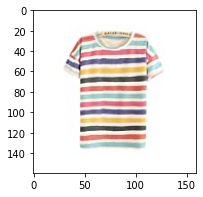

Title: Women's Cute Pastel Tops Tees Striped Design Print (Size M)
Euclidean similarity with the query point : 1.4142135623730951
ASIN : B019FLDX8A | Brand : Namnoi Cute Tee Top


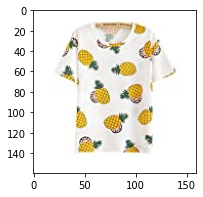

Title: Women's Tops Tees Pastel Cute Pineapple Design Print (Size M)
Euclidean similarity with the query point : 1.4142135623730951
ASIN : B017YNMK7Q | Brand : Namnoi Cute Tee Top


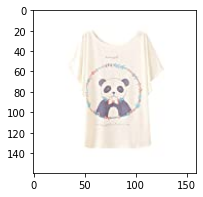

Title: Women's Cute Pastel Tops Tees Panda Design Print (Size M)
Euclidean similarity with the query point : 1.4142135623730951
ASIN : B017YNHX8W | Brand : Namnoi Cute Tee Top


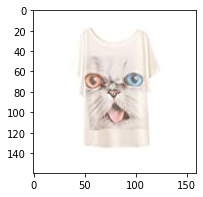

Title: Women's Cute Pastel Tops Tees Cat Design Print (Size M)
Euclidean similarity with the query point : 1.4142135623730951
ASIN : B017YLN5K4 | Brand : Namnoi Cute Tee Top


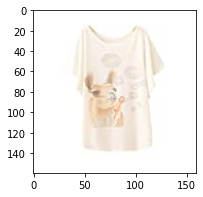

Title: Women's Cute Pastel Tops Tees Alpaca Design Print II (Size M)
Euclidean similarity with the query point : 1.7320508075688772
ASIN : B01G78XXRK | Brand : Namnoi Cute Tee Top


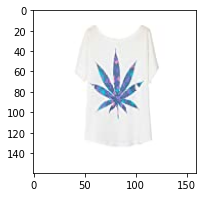

Title: Women's Cute Pastel Tops Tees Weeds Leaves Design Print (Size M)
Euclidean similarity with the query point : 1.7320508075688772
ASIN : B01G78D708 | Brand : Namnoi Cute Tee Top


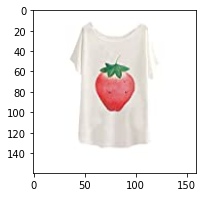

Title: Women's Cute Pastel Tops Tees Shy Strawberry Design Print (Size M)
Euclidean similarity with the query point : 1.7320508075688772
ASIN : B017YL7DE8 | Brand : Namnoi Cute Tee Top


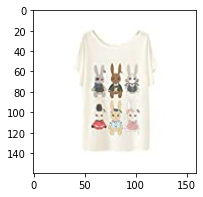

Title: Women's Cute Pastel Tops Tees Rabbit Design Print II (Size M)
Euclidean similarity with the query point : 1.7320508075688772


In [14]:
bag_of_words_model(1266,10)